In [1]:
import pywt
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.entropy import *
from kpnet.patterns import *
from kpnet.utils import *

from wavelets import *

In [33]:
N = 64
time_interval = 1000000

In [34]:
np.random.seed(0)
neuron = 5
# Period - N, 3, alpha=0.044, beta=0.2, gamma=3.2
net = KPNetworkTanhDelayed(N, 3, alpha=0.06, beta=0.2, gamma=3.2)

callbacks = {}
callbacks['N_' + str(neuron)] = NeuronActivityCallback(time_interval, neuron)

for i in range(N):
    callbacks['W_' + str(i)] = Weight0Callback(time_interval, neuron, i)
    
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(N), ZeroSignal(N)])
handler = ComputationHandler(time_interval)
%time results = handler.run(net, signal, callbacks)

CPU times: user 3min 17s, sys: 432 ms, total: 3min 18s
Wall time: 3min 18s


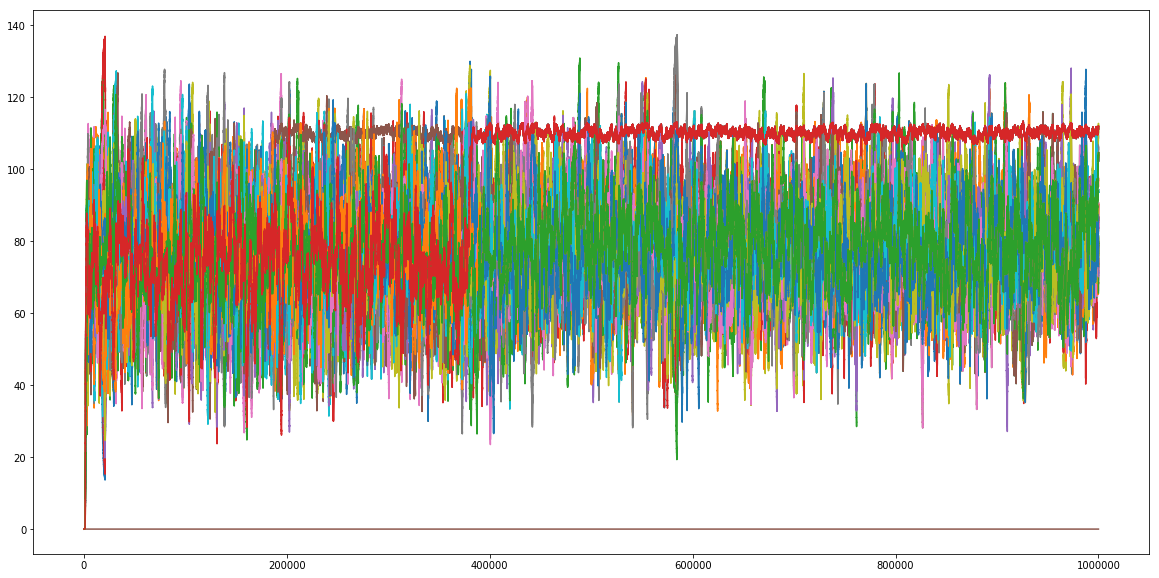

In [35]:
plt.figure(figsize=(20, 10))
for i in range(N):
    plt.plot(results['W_' + str(i)])
plt.show()

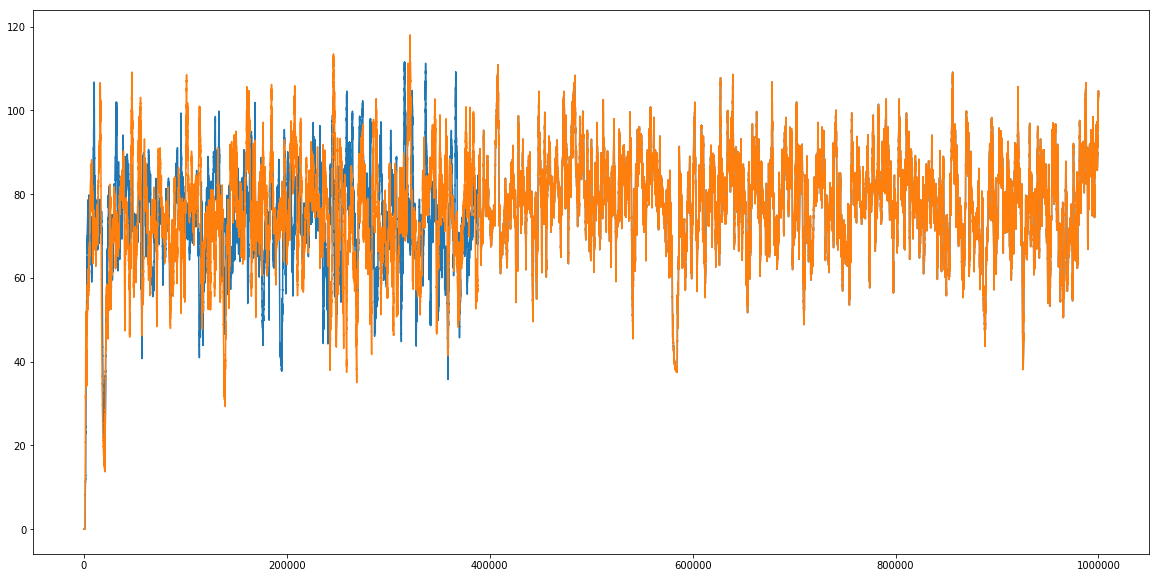

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(results['W_13'])
plt.plot(results['W_10'])
plt.show()

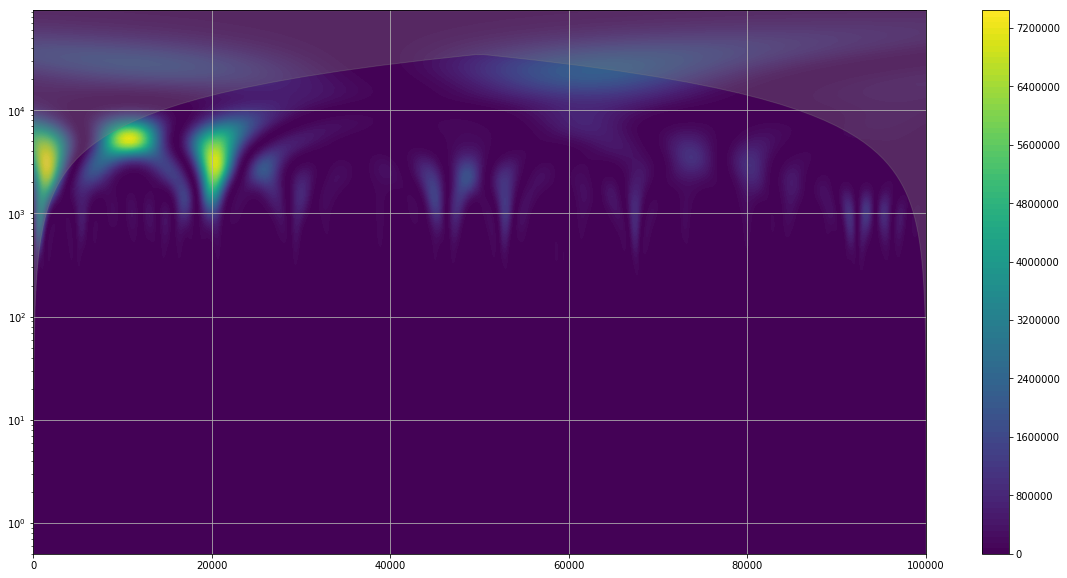

In [6]:
wa = WaveletAnalysis(results['W_9'], wavelet=Ricker())

fig = plt.figure(figsize=(20, 10)) 
ax = plt.subplot()
# wa.plot_power(ax)
Time, Scale = np.meshgrid(wa.time, wa.scales)
CS = ax.contourf(Time, Scale, wa.wavelet_power, 100)

ax.set_yscale('log')
ax.grid(True)

coi_time, coi_scale = wa.coi
ax.fill_between(x=coi_time,
                y1=coi_scale,
                y2=wa.scales.max(),
                color='gray',
                alpha=0.3)

ax.set_xlim(wa.time.min(), wa.time.max())
plt.colorbar(CS)
plt.show()

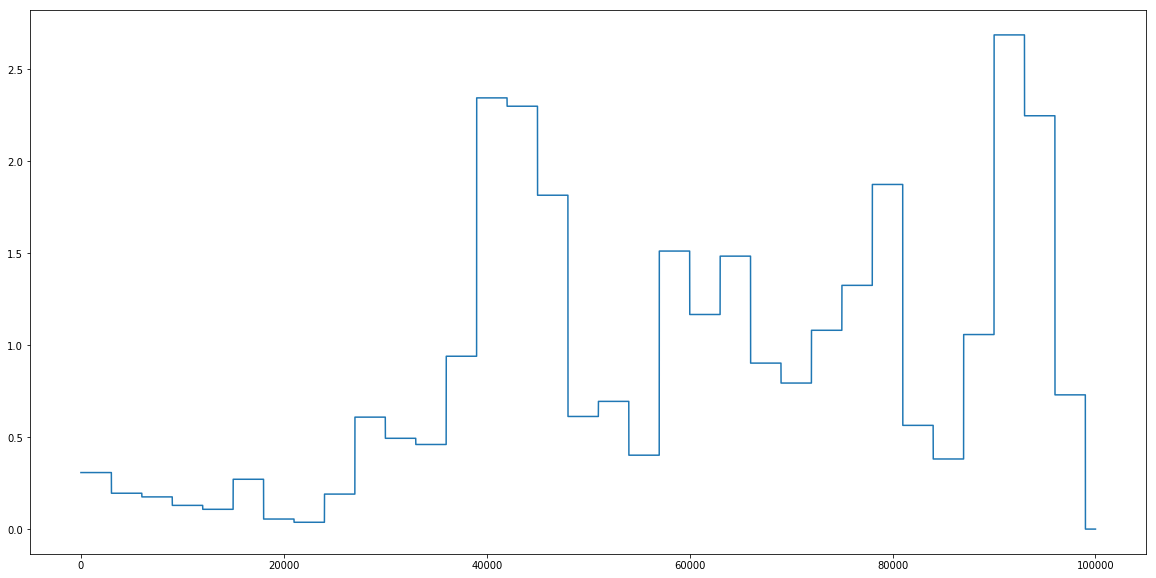

In [21]:
plt.figure(figsize=(20, 10))
ent_10 = EntropyCWT(results['W_9'], Ricker()) 
ent_13 = EntropyCWT(results['W_13'], Ricker())
values = EntropyCWT.compare_sliced(3000, ent_10, ent_13, EntropyCWT.distribution, EntropyCWT.jensen)
plt.plot(values)
plt.show()

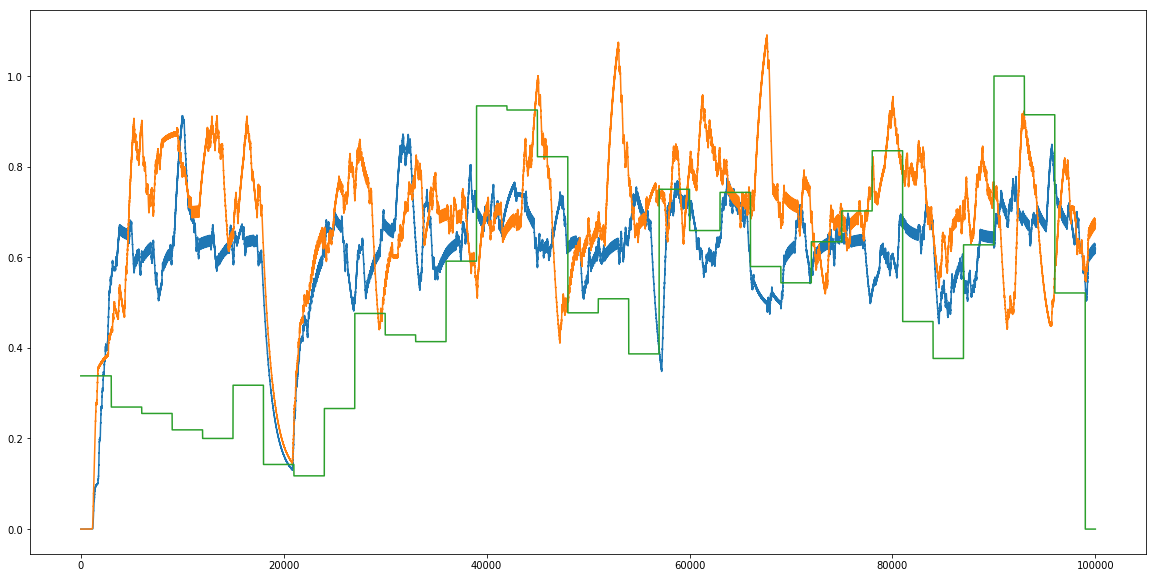

In [20]:
plt.figure(figsize=(20, 10))
ent_10 = EntropySWT(results['W_13'], Ricker()) 
ent_13 = EntropySWT(results['W_9'], Ricker())
values = EntropySWT.compare_sliced(3000, ent_10, ent_13, WaveletEntropy.distribution, WaveletEntropy.jensen)
plt.plot(results['W_13'] / np.max(results['W_0']))
plt.plot(results['W_9'] / np.max(results['W_13']))
plt.plot(np.sqrt(values) / np.sqrt(np.max(values)))
plt.show()

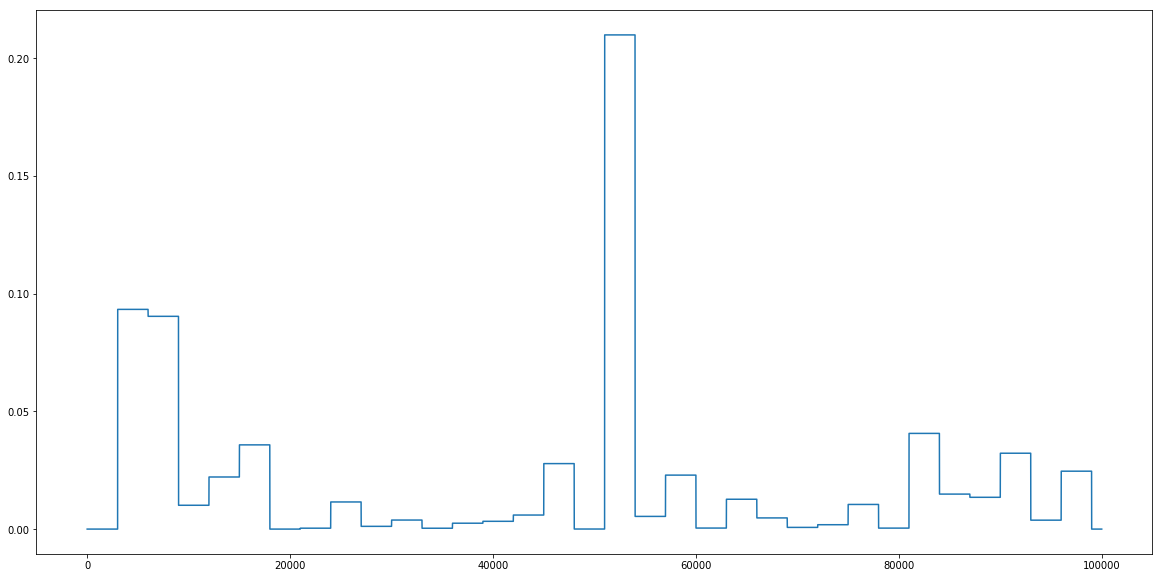

In [25]:
plt.figure(figsize=(20, 10))
ent_10 = EntropySWT(results['W_9'],  'db2') 
ent_13 = EntropySWT(results['W_13'], 'db2')
values = EntropySWT.compare_sliced(3000, ent_10, ent_13, EntropyCWT.distribution, EntropyCWT.jensen)
plt.plot(values)
plt.show()

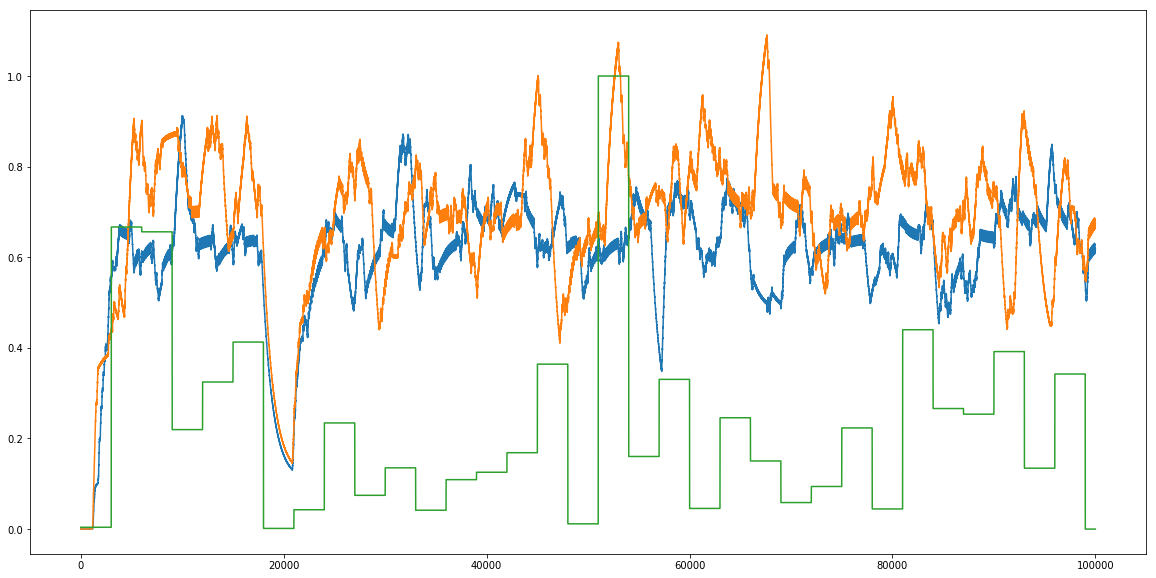

In [29]:
plt.figure(figsize=(20, 10))
ent_10 = EntropySWT(results['W_13'], 'db2') 
ent_13 = EntropySWT(results['W_9'], 'db2')
values = EntropySWT.compare_sliced(3000, ent_10, ent_13, WaveletEntropy.distribution, WaveletEntropy.jensen)
plt.plot(results['W_13'] / np.max(results['W_0']))
plt.plot(results['W_9'] / np.max(results['W_13']))
plt.plot(np.sqrt(values) / np.sqrt(np.max(values)))
plt.show()

In [26]:
packet = pywt.WaveletPacket(results['W_9'], 'db2')

In [ ]:
packet.w